In [1]:
import os
from pathlib import Path
import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

try:
    from tqdm.auto import tqdm
except Exception:
    tqdm = lambda x, **kwargs: x

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

BASE_DIR = Path(r"data/camelyon17_v1.0")  

PATCHES_DIR = BASE_DIR / "patches"
META_PATH   = BASE_DIR / "metadata.csv"

print("BASE_DIR:", BASE_DIR.resolve())
print("PATCHES_DIR exists:", PATCHES_DIR.exists())
print("META_PATH exists:", META_PATH.exists())


BASE_DIR: C:\Users\HugoG\Documents\GitHub\DATA-BI-projet-spe-2\data\camelyon17_v1.0
PATCHES_DIR exists: True
META_PATH exists: True


In [2]:
meta = pd.read_csv(META_PATH)

print("Shape:", meta.shape)
display(meta.head(10))
display(meta.describe(include="all").transpose().head(30))


Shape: (455954, 9)


Unnamed: 0  patient  node  x_coord  y_coord  tumor  slide  center  split
0           0        4     4     3328    21792      1      0       0      0
1           1        4     4     3200    22272      1      0       0      0
2           2        4     4     3168    22272      1      0       0      0
3           3        4     4     3328    21760      1      0       0      0
4           4        4     4     3232    22240      1      0       0      0
5           5        4     4     3168    22240      1      0       0      0
6           6        4     4     3136    22208      1      0       0      0
7           7        4     4     2656    18880      1      0       0      1
8           8        4     4     3136    22240      1      0       0      0
9           9        4     4     3296    21856      1      0       0      0

count           mean            std    min        25%       50%        75%       max
Unnamed: 0  455954.0  227976.500000  131622.726657    0.0  113988.25  227976.5  341964.75  455953.0
patient     455954.0      62.137053      27.795119    4.0      44.00      72.0      86.00      99.0
node        455954.0       1.759796       1.462122    0.0       1.00       1.0       3.00       4.0
x_coord     455954.0   16371.002899    9960.497762  160.0    7904.00   15616.0   22624.00   43776.0
y_coord     455954.0   20426.509832   12735.245587  160.0    9472.00   18048.0   30912.00   52160.0
tumor       455954.0       0.500000       0.500001    0.0       0.00       0.5       1.00       1.0
slide       455954.0      31.668749      14.348881    0.0      23.00      37.0      43.00      49.0
center      455954.0       2.591082       1.349268    0.0       2.00       3.0       4.00       4.0
split       455954.0       0.099999       0.299999    0.0       0.00       0.0       0.00       1.0

In [3]:
expected_cols = {"patient", "node", "x_coord", "y_coord", "tumor", "slide", "center", "split"}
missing = expected_cols - set(meta.columns)
if missing:
    raise ValueError(f"Colonnes manquantes dans metadata.csv: {missing}")

for c in ["patient", "node", "x_coord", "y_coord", "tumor", "center", "split"]:
    meta[c] = pd.to_numeric(meta[c], errors="coerce")

print("NaNs par colonne:\n", meta.isna().sum().sort_values(ascending=False).head(20))

print("tumor unique:", sorted(meta["tumor"].dropna().unique().tolist()))



NaNs par colonne:
 Unnamed: 0    0
patient       0
node          0
x_coord       0
y_coord       0
tumor         0
slide         0
center        0
split         0
dtype: int64
tumor unique: [0, 1]


In [4]:

def patient_node_folder(patient_id: int, node_id: int) -> str:
    return f"patient_{int(patient_id):03d}_node_{int(node_id)}"

def patch_filename(patient: int, node: int, x: int, y: int) -> str:
    return f"patch_patient_{int(patient):03d}_node_{int(node)}_x_{int(x)}_y_{int(y)}.png"


meta["folder"] = meta.apply(lambda r: patient_node_folder(r["patient"], r["node"]), axis=1)
meta["file"] = meta.apply(
    lambda r: patch_filename(r["patient"], r["node"], r["x_coord"], r["y_coord"]),
    axis=1
)
meta["path"]   = meta.apply(lambda r: str(PATCHES_DIR / r["folder"] / r["file"]), axis=1)

display(meta[["patient","node","x_coord","y_coord","tumor","center","split","folder","file","path"]].head(10))


patient  node  x_coord  y_coord  tumor  center  split              folder                                         file  \
0        4     4     3328    21792      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3328_y_21792.png   
1        4     4     3200    22272      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3200_y_22272.png   
2        4     4     3168    22272      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3168_y_22272.png   
3        4     4     3328    21760      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3328_y_21760.png   
4        4     4     3232    22240      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3232_y_22240.png   
5        4     4     3168    22240      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3168_y_22240.png   
6        4     4     3136    22208      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3136_y_22208.png   
7        4     4     2656    18880      1       0      1  patient_004_node_4  patch_patient_004_node_4_x_2656_y_18880.png   
8        4     4     3136    22240      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3136_y_22240.png   
9        4     4     3296    21856      1       0      0  patient_004_node_4  patch_patient_004_node_4_x_3296_y_21856.png   

                                                path  
0  data\camelyon17_v1.0\patches\patient_004_node_...  
1  data\camelyon17_v1.0\patches\patient_004_node_...  
2  data\camelyon17_v1.0\patches\patient_004_node_...  
3  data\camelyon17_v1.0\patches\patient_004_node_...  
4  data\camelyon17_v1.0\patches\patient_004_node_...  
5  data\camelyon17_v1.0\patches\patient_004_node_...  
6  data\camelyon17_v1.0\patches\patient_004_node_...  
7  data\camelyon17_v1.0\patches\patient_004_node_...  
8  data\camelyon17_v1.0\patches\patient_004_node_...  
9  data\camelyon17_v1.0\patches\patient_004_node_...

In [5]:

SAMPLE_CHECK = 5000  
sample_idx = meta.sample(min(SAMPLE_CHECK, len(meta)), random_state=42).index
exists_sample = meta.loc[sample_idx, "path"].map(lambda p: Path(p).exists())

print(f"Fichiers existants (échantillon n={len(sample_idx)}): {exists_sample.mean()*100:.2f}%")
if exists_sample.mean() < 0.95:
    print("Beaucoup de fichiers semblent manquants. Vérifie BASE_DIR / PATCHES_DIR ou le naming des PNG.")


Fichiers existants (échantillon n=5000): 100.00%


Counts tumor:
 tumor
0    227977
1    227977
Name: count, dtype: int64

Proportions (%):
 tumor
0    50.0
1    50.0
Name: proportion, dtype: float64


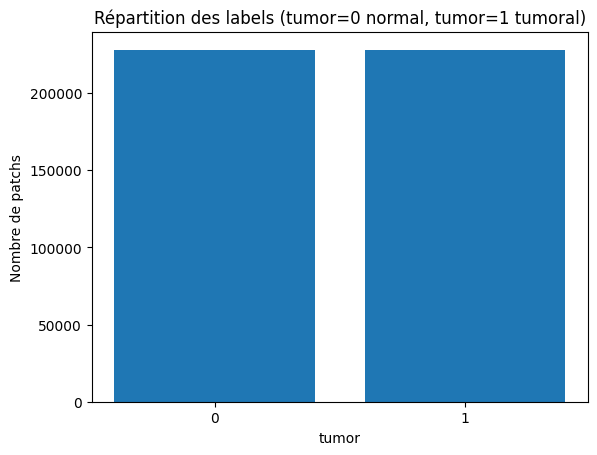

In [6]:

counts = meta["tumor"].value_counts(dropna=False).sort_index()
props  = meta["tumor"].value_counts(normalize=True, dropna=False).sort_index() * 100

print("Counts tumor:\n", counts)
print("\nProportions (%):\n", props.round(3))

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Répartition des labels (tumor=0 normal, tumor=1 tumoral)")
plt.xlabel("tumor")
plt.ylabel("Nombre de patchs")
plt.show()


Split counts:
 split
0    410359
1     45595
Name: count, dtype: int64


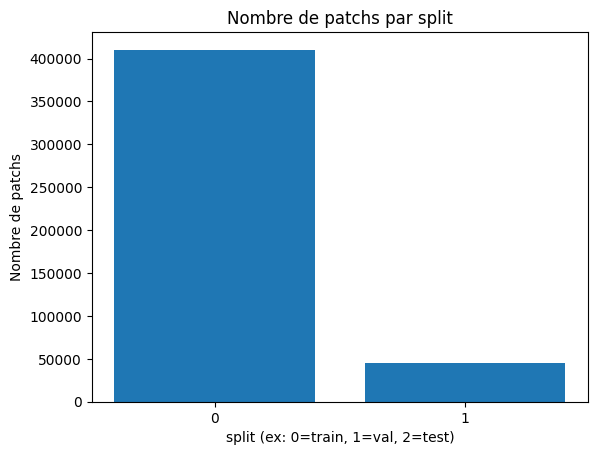

tumor      0      1
split              
0      49.96  50.04
1      50.33  49.67

tumor       0       1
split                
0      205031  205328
1       22946   22649

In [7]:
split_counts = meta["split"].value_counts().sort_index()
print("Split counts:\n", split_counts)

plt.figure()
plt.bar(split_counts.index.astype(int).astype(str), split_counts.values)
plt.title("Nombre de patchs par split")
plt.xlabel("split (ex: 0=train, 1=val, 2=test)")
plt.ylabel("Nombre de patchs")
plt.show()

# Tableau croisé split x tumor
ct_split_tumor = pd.crosstab(meta["split"], meta["tumor"], normalize="index") * 100
display(ct_split_tumor.round(2))

ct_split_tumor_counts = pd.crosstab(meta["split"], meta["tumor"])
display(ct_split_tumor_counts)


n_patches  tumor_rate_%
center                         
0           59436          50.0
1           34904          50.0
2           85054          50.0
3          129838          50.0
4          146722          50.0

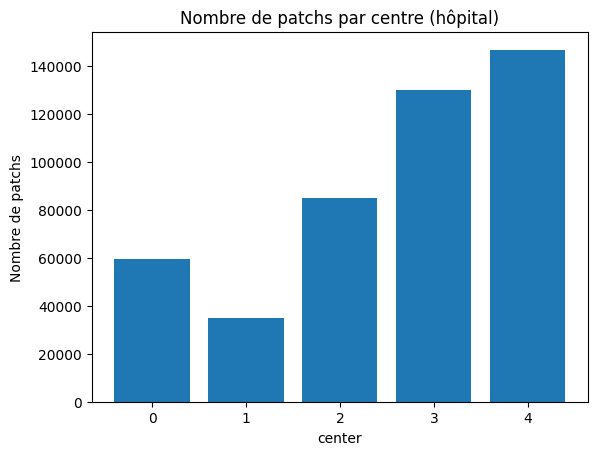

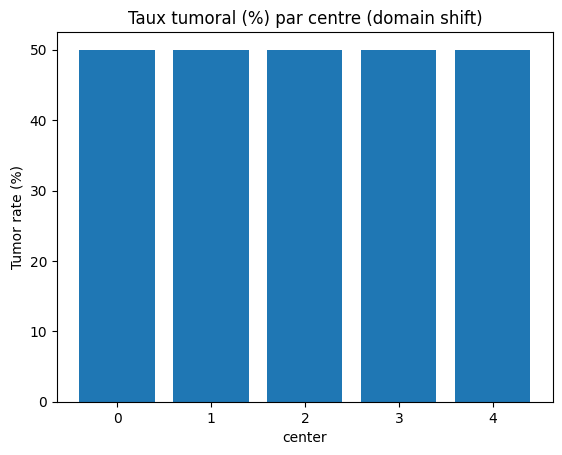

In [8]:
center_size = meta.groupby("center").size().sort_index()
center_tumor_rate = meta.groupby("center")["tumor"].mean().sort_index() * 100

display(pd.DataFrame({
    "n_patches": center_size,
    "tumor_rate_%": center_tumor_rate.round(3)
}))

plt.figure()
plt.bar(center_size.index.astype(int).astype(str), center_size.values)
plt.title("Nombre de patchs par centre (hôpital)")
plt.xlabel("center")
plt.ylabel("Nombre de patchs")
plt.show()

plt.figure()
plt.bar(center_tumor_rate.index.astype(int).astype(str), center_tumor_rate.values)
plt.title("Taux tumoral (%) par centre (domain shift)")
plt.xlabel("center")
plt.ylabel("Tumor rate (%)")
plt.show()


patches_per_patient
count            43.000000
mean          10603.581395
std           12361.583993
min            1275.000000
25%            4032.500000
50%            7210.000000
75%           11093.500000
max           61110.000000

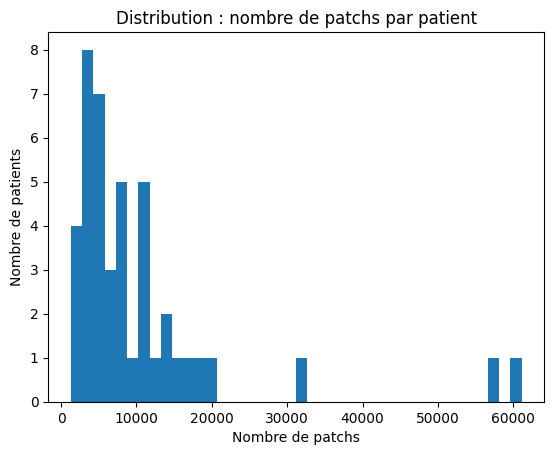

n_patches_top15
patient                 
96                 61110
73                 57375
51                 31878
75                 19485
17                 18859
99                 16354
86                 15806
92                 14703
12                 13637
52                 12742
81                 11526
68                 10661
60                 10623
15                 10554
22                 10404

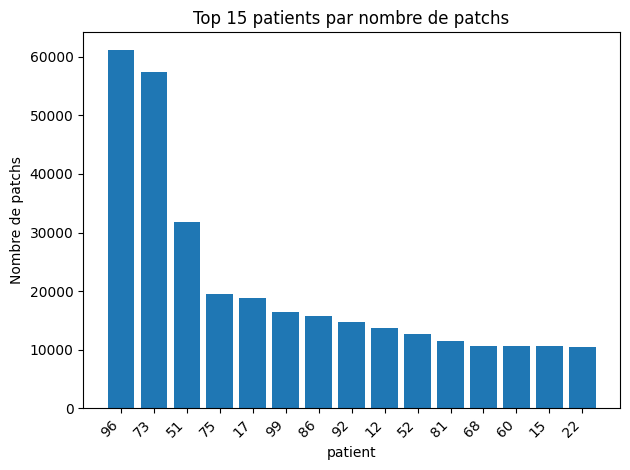

In [9]:
patches_per_patient = meta.groupby("patient").size()

display(patches_per_patient.describe().to_frame("patches_per_patient"))

plt.figure()
plt.hist(patches_per_patient.values, bins=40)
plt.title("Distribution : nombre de patchs par patient")
plt.xlabel("Nombre de patchs")
plt.ylabel("Nombre de patients")
plt.show()

top_patients = patches_per_patient.sort_values(ascending=False).head(15)
display(top_patients.to_frame("n_patches_top15"))

plt.figure()
plt.bar(top_patients.index.astype(int).astype(str), top_patients.values)
plt.title("Top 15 patients par nombre de patchs")
plt.xlabel("patient")
plt.ylabel("Nombre de patchs")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


Patients sans/avec métastase (proxy):
 tumor
1    43
Name: count, dtype: int64

Proportions (%):
 tumor
1    100.0
Name: proportion, dtype: float64


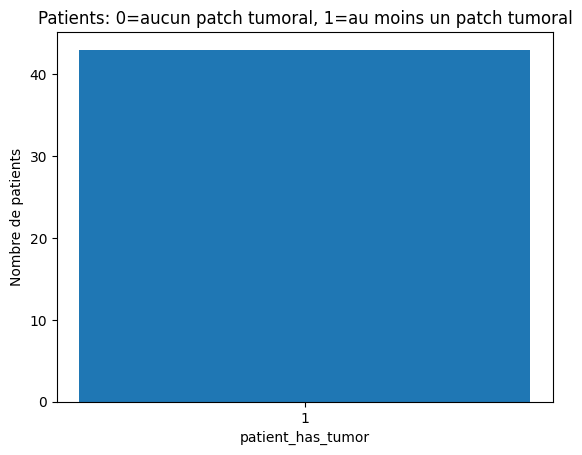

In [10]:
patient_has_tumor = meta.groupby("patient")["tumor"].max()
counts_patient = patient_has_tumor.value_counts().sort_index()
props_patient = patient_has_tumor.value_counts(normalize=True).sort_index() * 100

print("Patients sans/avec métastase (proxy):\n", counts_patient)
print("\nProportions (%):\n", props_patient.round(2))

plt.figure()
plt.bar(counts_patient.index.astype(int).astype(str), counts_patient.values)
plt.title("Patients: 0=aucun patch tumoral, 1=au moins un patch tumoral")
plt.xlabel("patient_has_tumor")
plt.ylabel("Nombre de patients")
plt.show()


nodes_per_patient
count          43.000000
mean            1.162791
std             0.432613
min             1.000000
25%             1.000000
50%             1.000000
75%             1.000000
max             3.000000

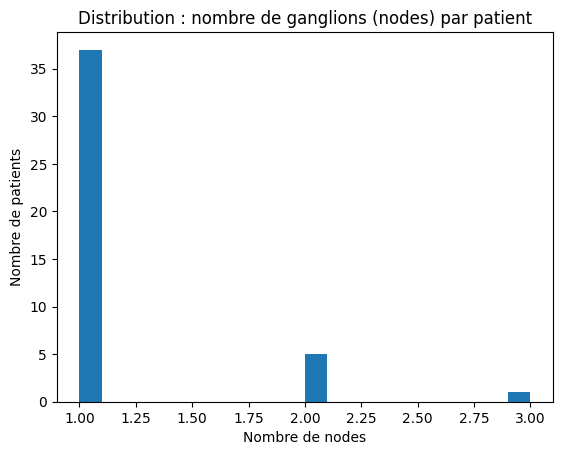

patches_per_node
count         50.000000
mean        9119.080000
std        11696.963173
min          888.000000
25%         3808.500000
50%         5313.500000
75%        10010.750000
max        61110.000000

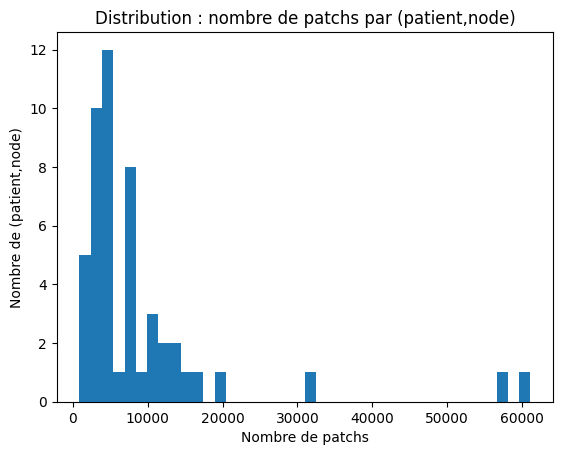

In [11]:
nodes_per_patient = meta.groupby("patient")["node"].nunique()
display(nodes_per_patient.describe().to_frame("nodes_per_patient"))

plt.figure()
plt.hist(nodes_per_patient.values, bins=20)
plt.title("Distribution : nombre de ganglions (nodes) par patient")
plt.xlabel("Nombre de nodes")
plt.ylabel("Nombre de patients")
plt.show()

patches_per_node = meta.groupby(["patient","node"]).size()
display(patches_per_node.describe().to_frame("patches_per_node"))

plt.figure()
plt.hist(patches_per_node.values, bins=40)
plt.title("Distribution : nombre de patchs par (patient,node)")
plt.xlabel("Nombre de patchs")
plt.ylabel("Nombre de (patient,node)")
plt.show()


patient_tumor_rate_%
count             43.000000
mean              27.310027
std               32.180891
min                0.113881
25%                1.191944
50%                6.678268
75%               52.334500
max               92.755005

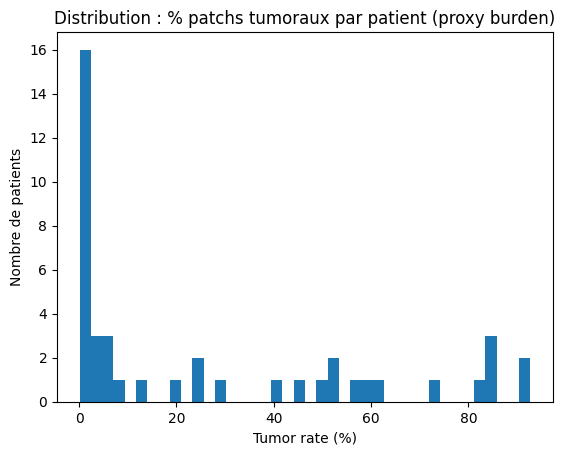

tumor_rate_%_top15
patient                    
12                92.755005
96                92.727868
51                84.691637
22                84.352172
73                83.886710
34                82.357675
75                72.009238
99                61.422282
42                58.654646
15                57.447413
52                52.456443
44                52.212557
17                50.193542
20                45.643711
92                40.461130

In [12]:
patient_tumor_rate = meta.groupby("patient")["tumor"].mean() * 100
display(patient_tumor_rate.describe().to_frame("patient_tumor_rate_%"))

plt.figure()
plt.hist(patient_tumor_rate.values, bins=40)
plt.title("Distribution : % patchs tumoraux par patient (proxy burden)")
plt.xlabel("Tumor rate (%)")
plt.ylabel("Nombre de patients")
plt.show()

# Exemples de patients avec forte proportion tumorale
display(patient_tumor_rate.sort_values(ascending=False).head(15).to_frame("tumor_rate_%_top15"))


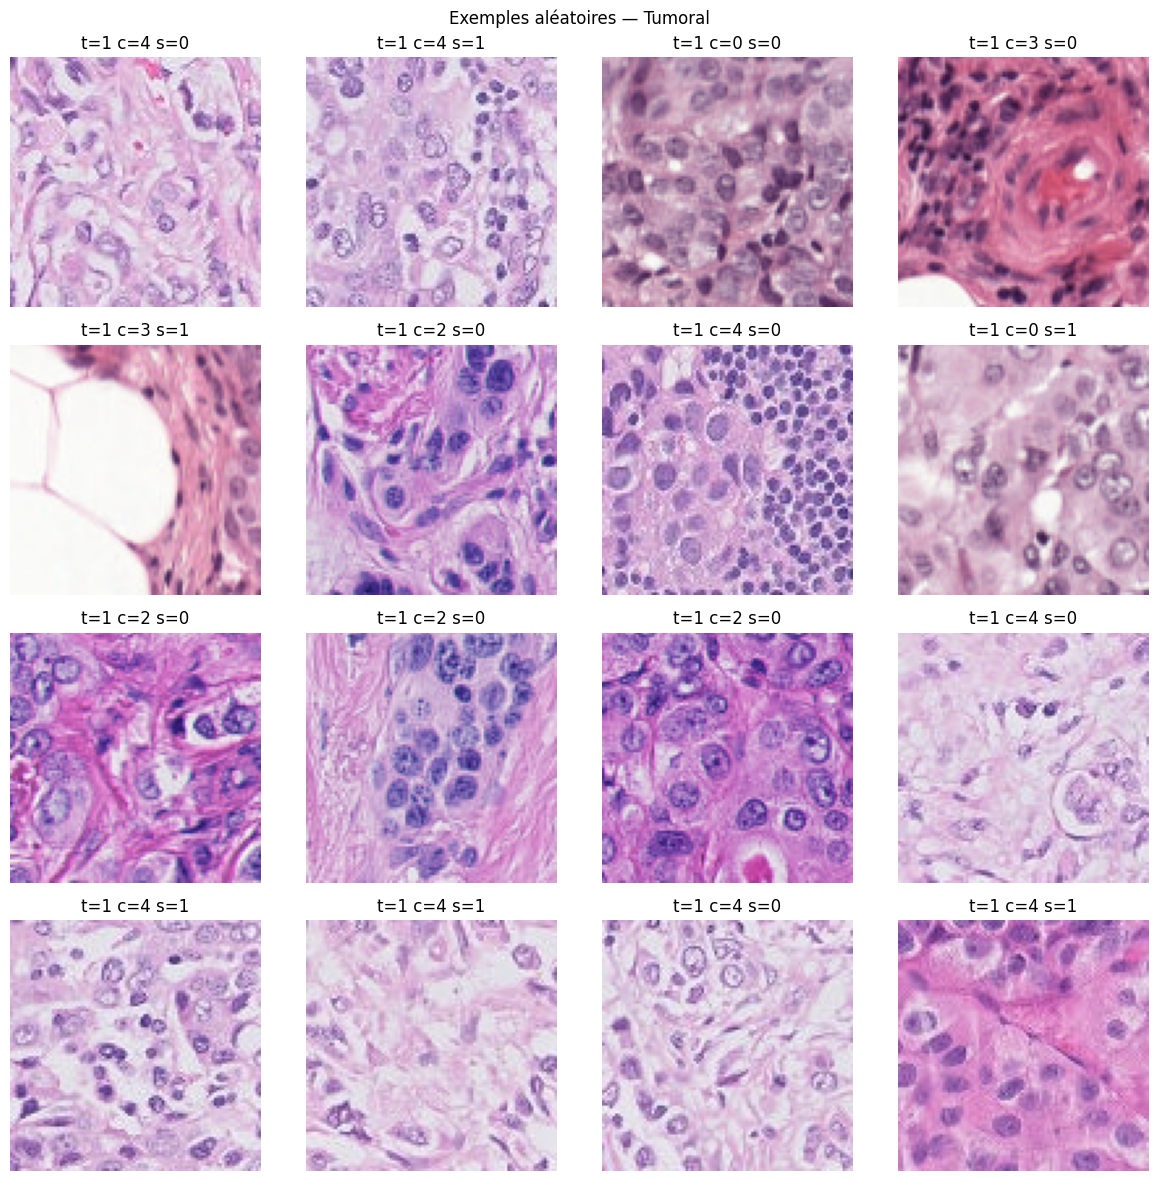

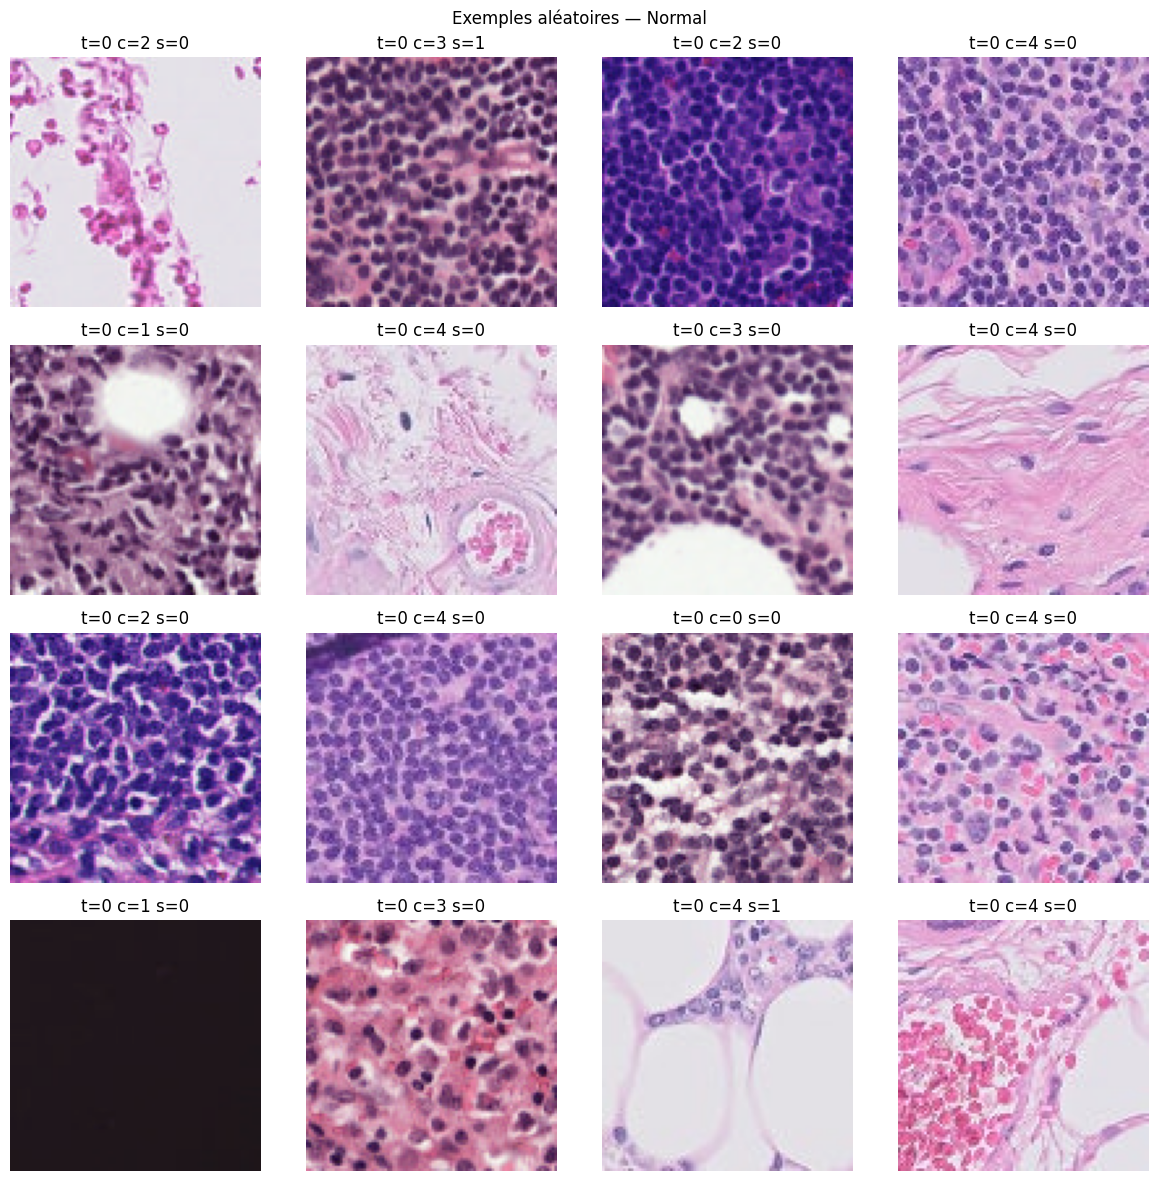

In [13]:
def show_random_patches(meta_df, n=12, title=None, seed=0):
    rnd = meta_df.sample(n=min(n, len(meta_df)), random_state=seed).copy()
    cols = int(math.sqrt(n))
    rows = int(math.ceil(n / cols))
    plt.figure(figsize=(3*cols, 3*rows))
    for i, (_, r) in enumerate(rnd.iterrows(), start=1):
        p = Path(r["path"])
        plt.subplot(rows, cols, i)
        if p.exists():
            img = Image.open(p).convert("RGB")
            plt.imshow(img)
            plt.title(f"t={int(r['tumor'])} c={int(r['center'])} s={int(r['split'])}")
        else:
            plt.text(0.5, 0.5, "MISSING", ha="center", va="center")
        plt.axis("off")
    if title:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Patches tumoraux
show_random_patches(meta[meta["tumor"]==1], n=16, title="Exemples aléatoires — Tumoral", seed=1)

# Patches normaux
show_random_patches(meta[meta["tumor"]==0], n=16, title="Exemples aléatoires — Normal", seed=2)


In [14]:


def compute_rgb_stats(paths, max_images=2000, seed=42):
    paths = list(paths)
    random.Random(seed).shuffle(paths)
    paths = paths[:min(max_images, len(paths))]

    means = []
    stds  = []
    n_ok = 0
    for p in tqdm(paths, desc="RGB stats"):
        p = Path(p)
        if not p.exists():
            continue
        img = Image.open(p).convert("RGB")
        arr = np.asarray(img).astype(np.float32) / 255.0
        means.append(arr.mean(axis=(0,1)))
        stds.append(arr.std(axis=(0,1)))
        n_ok += 1

    if n_ok == 0:
        return None

    means = np.vstack(means)
    stds  = np.vstack(stds)
    return {
        "n_images": n_ok,
        "mean_rgb": means.mean(axis=0),
        "std_rgb":  stds.mean(axis=0),
        "means_all": means,
        "stds_all": stds
    }

# Échantillon global
stats_global = compute_rgb_stats(meta["path"].values, max_images=1500, seed=0)
if stats_global:
    print("N images:", stats_global["n_images"])
    print("Mean RGB:", stats_global["mean_rgb"])
    print("Std  RGB:", stats_global["std_rgb"])


RGB stats:   0%|          | 0/1500 [00:00<?, ?it/s]

N images: 1500
Mean RGB: [0.7228256  0.56033456 0.71459246]
Std  RGB: [0.13339622 0.15275814 0.11000258]


RGB stats:   0%|          | 0/500 [00:00<?, ?it/s]

RGB stats:   0%|          | 0/500 [00:00<?, ?it/s]

RGB stats:   0%|          | 0/500 [00:00<?, ?it/s]

RGB stats:   0%|          | 0/500 [00:00<?, ?it/s]

RGB stats:   0%|          | 0/500 [00:00<?, ?it/s]

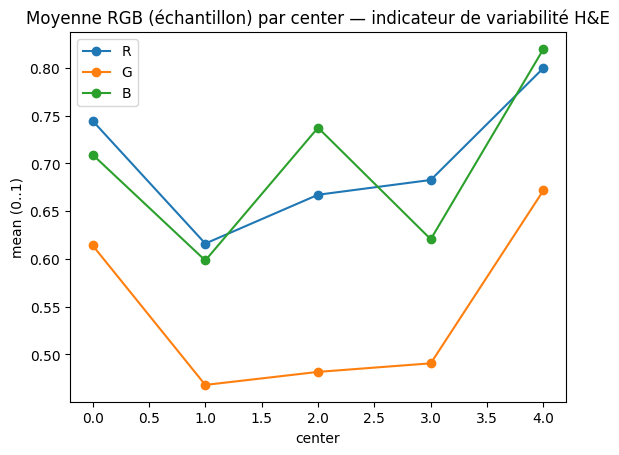

In [15]:
centers = sorted(meta["center"].dropna().unique().astype(int).tolist())

center_stats = {}
for c in centers:
    sub = meta[meta["center"]==c]
    stats = compute_rgb_stats(sub["path"].values, max_images=500, seed=0)
    if stats:
        center_stats[c] = stats

# Plot des moyennes RGB par center
if center_stats:
    plt.figure()
    xs = list(center_stats.keys())
    meanR = [center_stats[c]["mean_rgb"][0] for c in xs]
    meanG = [center_stats[c]["mean_rgb"][1] for c in xs]
    meanB = [center_stats[c]["mean_rgb"][2] for c in xs]
    plt.plot(xs, meanR, marker="o", label="R")
    plt.plot(xs, meanG, marker="o", label="G")
    plt.plot(xs, meanB, marker="o", label="B")
    plt.title("Moyenne RGB (échantillon) par center — indicateur de variabilité H&E")
    plt.xlabel("center")
    plt.ylabel("mean (0..1)")
    plt.legend()
    plt.show()


In [16]:


def count_pngs_in_folders(patches_dir: Path, max_folders=None):
    folders = [p for p in patches_dir.iterdir() if p.is_dir()]
    folders = sorted(folders)
    if max_folders is not None:
        folders = folders[:max_folders]
    rows = []
    for f in tqdm(folders, desc="Counting PNGs"):
        n = sum(1 for _ in f.glob("*.png"))
        rows.append({"folder": f.name, "n_png": n})
    return pd.DataFrame(rows)

df_folder_png = count_pngs_in_folders(PATCHES_DIR)
display(df_folder_png.sort_values("n_png", ascending=False).head(20))

meta_folder_counts = meta.groupby("folder").size().reset_index(name="n_meta")
merged = df_folder_png.merge(meta_folder_counts, on="folder", how="outer")
merged["diff"] = merged["n_png"].fillna(0).astype(int) - merged["n_meta"].fillna(0).astype(int)

display(merged.sort_values("diff", ascending=False).head(20))
display(merged.sort_values("diff", ascending=True).head(20))

print("Folders totaux sur disque:", len(df_folder_png))
print("Folders dans metadata:", meta["folder"].nunique())
print("Somme PNG sur disque:", int(df_folder_png["n_png"].sum()))
print("Lignes metadata:", len(meta))


Counting PNGs:   0%|          | 0/50 [00:00<?, ?it/s]

folder  n_png
48  patient_096_node_0  61110
38  patient_073_node_1  57375
28  patient_051_node_2  31878
39  patient_075_node_4  19485
49  patient_099_node_4  16354
47  patient_092_node_1  14703
3   patient_012_node_0  13637
8   patient_017_node_2  13455
29  patient_052_node_1  12742
41  patient_081_node_4  11526
36  patient_068_node_1  10661
30  patient_060_node_3  10623
13  patient_022_node_4  10404
32  patient_062_node_2   8831
44  patient_087_node_0   7958
43  patient_086_node_4   7939
42  patient_086_node_0   7867
24  patient_045_node_1   7727
40  patient_080_node_1   7395
4   patient_015_node_1   7294

folder  n_png  n_meta  diff
0   patient_004_node_4   4316    4316     0
1   patient_009_node_1   4597    4597     0
2   patient_010_node_4   4046    4046     0
3   patient_012_node_0  13637   13637     0
4   patient_015_node_1   7294    7294     0
5   patient_015_node_2   3260    3260     0
6   patient_016_node_1   3427    3427     0
7   patient_017_node_1   1596    1596     0
8   patient_017_node_2  13455   13455     0
9   patient_017_node_4   3808    3808     0
10  patient_020_node_2   2078    2078     0
11  patient_020_node_4   5371    5371     0
12  patient_021_node_3   1705    1705     0
13  patient_022_node_4  10404   10404     0
14  patient_024_node_1    888     888     0
15  patient_024_node_2   2966    2966     0
16  patient_034_node_3   4971    4971     0
17  patient_036_node_3   2659    2659     0
18  patient_038_node_2   1275    1275     0
19  patient_039_node_1   2587    2587     0

folder  n_png  n_meta  diff
0   patient_004_node_4   4316    4316     0
1   patient_009_node_1   4597    4597     0
2   patient_010_node_4   4046    4046     0
3   patient_012_node_0  13637   13637     0
4   patient_015_node_1   7294    7294     0
5   patient_015_node_2   3260    3260     0
6   patient_016_node_1   3427    3427     0
7   patient_017_node_1   1596    1596     0
8   patient_017_node_2  13455   13455     0
9   patient_017_node_4   3808    3808     0
10  patient_020_node_2   2078    2078     0
11  patient_020_node_4   5371    5371     0
12  patient_021_node_3   1705    1705     0
13  patient_022_node_4  10404   10404     0
14  patient_024_node_1    888     888     0
15  patient_024_node_2   2966    2966     0
16  patient_034_node_3   4971    4971     0
17  patient_036_node_3   2659    2659     0
18  patient_038_node_2   1275    1275     0
19  patient_039_node_1   2587    2587     0

Folders totaux sur disque: 50
Folders dans metadata: 50
Somme PNG sur disque: 455954
Lignes metadata: 455954


In [17]:

summary = {}

summary["n_patches_total"] = int(len(meta))
summary["n_patients"] = int(meta["patient"].nunique())
summary["n_patient_nodes"] = int(meta.groupby(["patient","node"]).ngroups)
summary["class_counts"] = meta["tumor"].value_counts().to_dict()
summary["class_props_%"] = (meta["tumor"].value_counts(normalize=True)*100).round(3).to_dict()
summary["split_counts"] = meta["split"].value_counts().sort_index().to_dict()
summary["center_counts"] = meta["center"].value_counts().sort_index().to_dict()
summary["center_tumor_rate_%"] = (meta.groupby("center")["tumor"].mean()*100).round(3).to_dict()

summary["patches_per_patient_mean"] = float(patches_per_patient.mean())
summary["patches_per_patient_median"] = float(patches_per_patient.median())
summary["patches_per_patient_min"] = int(patches_per_patient.min())
summary["patches_per_patient_max"] = int(patches_per_patient.max())

summary["nodes_per_patient_mean"] = float(nodes_per_patient.mean())
summary["nodes_per_patient_median"] = float(nodes_per_patient.median())

summary["patients_with_any_tumor"] = int((patient_has_tumor==1).sum())
summary["patients_without_tumor"] = int((patient_has_tumor==0).sum())

pd.Series(summary)


n_patches_total                                                          455954
n_patients                                                                   43
n_patient_nodes                                                              50
class_counts                                             {1: 227977, 0: 227977}
class_props_%                                                {1: 50.0, 0: 50.0}
split_counts                                              {0: 410359, 1: 45595}
center_counts                 {0: 59436, 1: 34904, 2: 85054, 3: 129838, 4: 1...
center_tumor_rate_%               {0: 50.0, 1: 50.0, 2: 50.0, 3: 50.0, 4: 50.0}
patches_per_patient_mean                                           10603.581395
patches_per_patient_median                                               7210.0
patches_per_patient_min                                                    1275
patches_per_patient_max                                                   61110
nodes_per_patient_mean                  